In [9]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
from collections import Counter

warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/spamar.csv", encoding='utf-8')
df.head()

# Verify column names
print(df.columns)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Index(['V1', 'V2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')


In [10]:
# Drop redundant columns and rename columns
df = df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df.rename(columns={"V1": "Target", "V2": "Text"}, inplace=True)

# Check the first few rows
df.head()



,Target,Text
0,spam,دخول مجاني في 2 أسبوع للفوز بنهائي كأس الاتحاد...
1,ham,يو دون يقول ذلك في وقت مبكر من اليوم... ثم تقو...
2,ham,لا أعتقد أنه يذهب إلى USF، فهو يعيش هنا على ال...
3,spam,FreeMsg مرحبًا يا عزيزي، لقد مر 3 أسابيع الآن ...
4,ham,حتى شقيقي لا يحب التحدث معي. يعاملونني مثل برا...


In [11]:
# Check for NaN values in the 'Text' column
print(df['Text'].isna().sum())

# Fill NaN values with an empty string
df['Text'].fillna('', inplace=True)

# Verify there are no NaN values
print(df['Text'].isna().sum())

# Check for NaN values in the 'Target' column
print(df['Target'].isna().sum())

# Drop rows where 'Target' is NaN
df.dropna(subset=['Target'], inplace=True)

# Verify there are no NaN values in 'Target'
print(df['Target'].isna().sum())



1
0
1
0


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


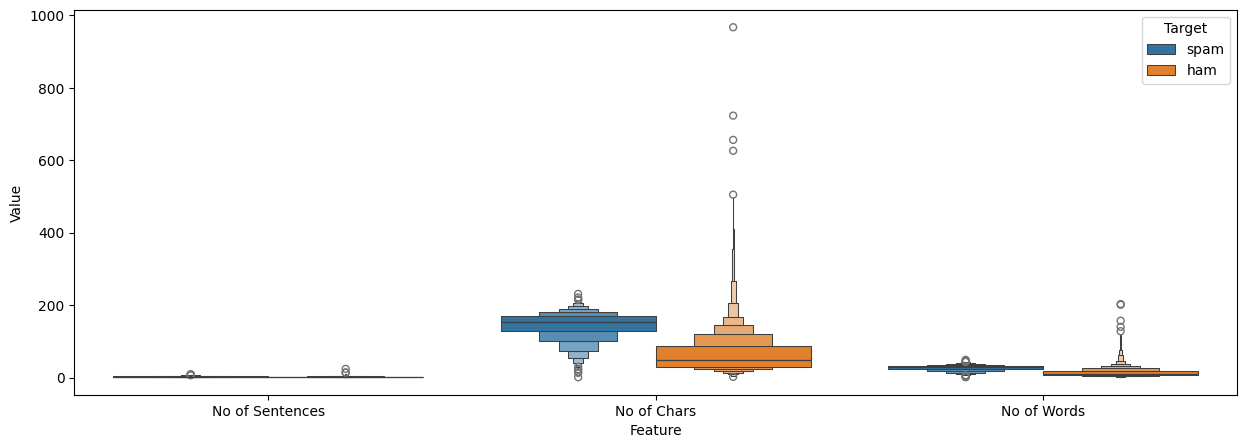

(5375, 5)

In [12]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Add new features for number of characters, sentences, and words
df['No of Chars'] = df['Text'].apply(len)
df['No of Sentences'] = df['Text'].apply(lambda corpus: nltk.sent_tokenize(corpus)).apply(len)
df['No of Words'] = df['Text'].apply(lambda document: nltk.word_tokenize(document)).apply(len)

# Describe the data
df.describe().T

# Plot Boxplot for outlier detection
melted_df = df.melt(id_vars='Target', value_vars=['No of Sentences', 'No of Chars', 'No of Words'], var_name='Feature', value_name='Value')
plt.figure(figsize=(15,5))
sns.boxenplot(x='Feature', y='Value', data=melted_df, hue='Target')
plt.show()

# Identify and remove outliers using IQR
column_name = 'No of Chars'
Q1 = df[column_name].quantile(0.25)
Q3 = df[column_name].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
df.drop(outliers.index, axis=0, inplace=True)

# Check the shape after removing outliers
df.shape




Index(['Target', 'Text', 'No of Chars', 'No of Sentences', 'No of Words'], dtype='object')


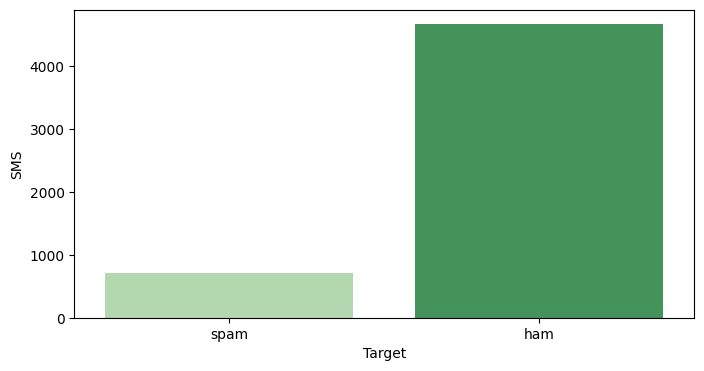

In [13]:
# Verify column names again
print(df.columns)

# Check the first few rows
df.head()

# Plot the distribution of the target feature
plt.figure(figsize=(8,4))
sns.countplot(data=df, x='Target', palette='Greens')
plt.xlabel("Target")
plt.ylabel("SMS")
plt.show()

In [14]:

# Function to clean the text data
def data_cleaning(text):
    text = re.sub('[^ا-ي]', ' ', text)  # Replace all non-Arabic characters with space
    text = text.lower()  # Convert text to lowercase
    text = text.split()  # Split text into list
    text = ' '.join(text)  # Join the list back into a string
    return text

# Apply data cleaning
df['Clean Text'] = df['Text'].apply(data_cleaning)

# Tokenize the cleaned text and generate n-grams
df['Tokenized Text'] = df['Clean Text'].apply(lambda document: nltk.word_tokenize(document))

# Generate unigrams, bigrams, and trigrams
def generate_ngrams(text, n):
    words = word_tokenize(text)
    n_grams = list(ngrams(words, n))
    return n_grams

df['Unigrams'] = df['Clean Text'].apply(lambda text: generate_ngrams(text, 1))
df['Bigrams'] = df['Clean Text'].apply(lambda text: generate_ngrams(text, 2))




In [15]:
# Function to remove stopwords
def stopwords_removal(tokens):
    stop_words = set(stopwords.words('arabic'))
    filtered_text = [word for word in tokens if word not in stop_words]
    return filtered_text

# Apply stopwords removal
df['Filtered Token'] = df['Tokenized Text'].apply(stopwords_removal)

# Lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to lemmatize tokens
def lemmatizing(tokens):
    lemmas = [lemmatizer.lemmatize(token, pos='v') for token in tokens]
    return lemmas

# Apply lemmatization
df['Lemmatized Tokens'] = df['Filtered Token'].apply(lemmatizing)

# Ensure `y` is correctly populated
df['Target'] = df['Target'].map({"ham": 0, "spam": 1})
df.dropna(subset=['Target'], inplace=True)
y = df['Target'].values

# Debug: Print the length of y to ensure it is populated correctly
print("Length of y:", len(y))



Length of y: 5375


Initial corpus: ['دخول مجاني سبوع للفوز بنها الاتحاد ال نجليزي رسال رسالة نصية لى لاستلام ال ال دخال معدل النص القياسي تطبق الشروط وال حكام', 'يو يقول وقت مبكر اليوم تقول يو سي بالفعل', 'عتقد نه يذهب لى فهو يعيش الرغم', 'مرحب عزيزي لقد مر سابيع ال ولم يرد رد زلت ترغب المتعة مرض السل', 'شقيقي يحب التحدث معي يعاملونني برا اختراع ال يدز']
Corpus after adding n-grams: ['دخول مجاني سبوع للفوز بنها الاتحاد ال نجليزي رسال رسالة نصية لى لاستلام ال ال دخال معدل النص القياسي تطبق الشروط وال حكام دخول مجاني في سبوع للفوز بنها ي ك س الاتحاد ال نجليزي مايو رسال رسالة نصية لى لاستلام س ال ال دخال معدل النص القياسي تطبق الشروط وال حكام على دخول مجاني مجاني في في سبوع سبوع للفوز للفوز بنها بنها ي ي ك ك س س الاتحاد الاتحاد ال ال نجليزي نجليزي مايو مايو رسال رسال رسالة رسالة نصية نصية لى لى لاستلام لاستلام س س ال ال ال ال دخال دخال معدل معدل النص النص القياسي القياسي تطبق تطبق الشروط الشروط وال وال حكام حكام على', 'يو يقول وقت مبكر اليوم تقول يو سي بالفعل يو دون يقول ذلك في وقت مبكر من اليوم ثم تقول يو 

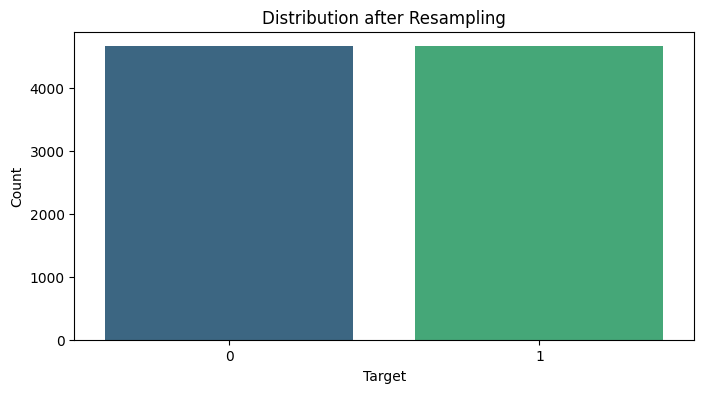

In [16]:

# Create a corpus of lemmatized tokens including n-grams
corpus = []
for tokens in df['Lemmatized Tokens']:
    document = ' '.join([word for word in tokens])
    corpus.append(document)

# Debug: Print the first few entries of the corpus
print("Initial corpus:", corpus[:5])

# Add n-grams to the corpus
for i in range(len(df)):
    unigrams = ' '.join([' '.join(gram) for gram in df['Unigrams'].iloc[i]])
    bigrams = ' '.join([' '.join(gram) for gram in df['Bigrams'].iloc[i]])

    corpus[i] += ' ' + unigrams + ' ' + bigrams

# Debug: Print the first few entries of the corpus after adding n-grams
print("Corpus after adding n-grams:", corpus[:5])

# Check if the corpus is empty or contains only stop words
if not corpus or all(doc.strip() == '' for doc in corpus):
    raise ValueError("The corpus is empty or contains only stop words.")

# Perform TF-IDF vectorization
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()

# Debug: Print the length of X to ensure it matches y
print("Length of X:", len(X))
# Resample the data using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Debug: Print the new distribution of y_resampled
print("Distribution after resampling:", Counter(y_resampled))

# Plot the distribution after resampling
plt.figure(figsize=(8,4))
sns.countplot(x=y_resampled, palette='viridis')
plt.xlabel("Target")
plt.ylabel("Count")
plt.title("Distribution after Resampling")
plt.show()


In [17]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define classifiers
classifiers = [LogisticRegression(), MultinomialNB(), RandomForestClassifier(), KNeighborsClassifier()]
clf_dict = {0: "Logistic Regression", 1: "NaiveBayes", 2: "RandomForest", 3: "KNeighbours"}

# Perform cross-validation and evaluate models
evaluation_results = []

for i, model in enumerate(classifiers):
    # Perform 10-fold cross-validation
    cv_score = cross_val_score(model, X_train, y_train, scoring="accuracy", cv=10)

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    # Append results to the list
    evaluation_results.append({
        'Model': clf_dict[i],
        'Cross-Validation Accuracy': cv_score.mean(),
        'Test Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

    print(f"{clf_dict[i]}: {round(accuracy*100, 2)}%")

# Create a DataFrame from the results
evaluation_df = pd.DataFrame(evaluation_results)
metric_category = ['Cross-Validation Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score']
evaluation_df[metric_category] = round(evaluation_df[metric_category]*100, 6)



Logistic Regression: 95.35%
NaiveBayes: 95.53%
RandomForest: 96.93%
KNeighbours: 90.79%


In [18]:
# Create a DataFrame from the results
evaluation_df = pd.DataFrame(evaluation_results)

# Display the results as a table
print(evaluation_df)


                 Model  Cross-Validation Accuracy  Test Accuracy  Precision  \
0  Logistic Regression                   0.948372       0.953488   0.954695   
1           NaiveBayes                   0.947209       0.955349   0.957534   
2         RandomForest                   0.966977       0.969302   0.970000   
3          KNeighbours                   0.902791       0.907907   0.916741   

     Recall  F1 Score  
0  0.953488  0.949553  
1  0.955349  0.951368  
2  0.969302  0.967672  
3  0.907907  0.885586  


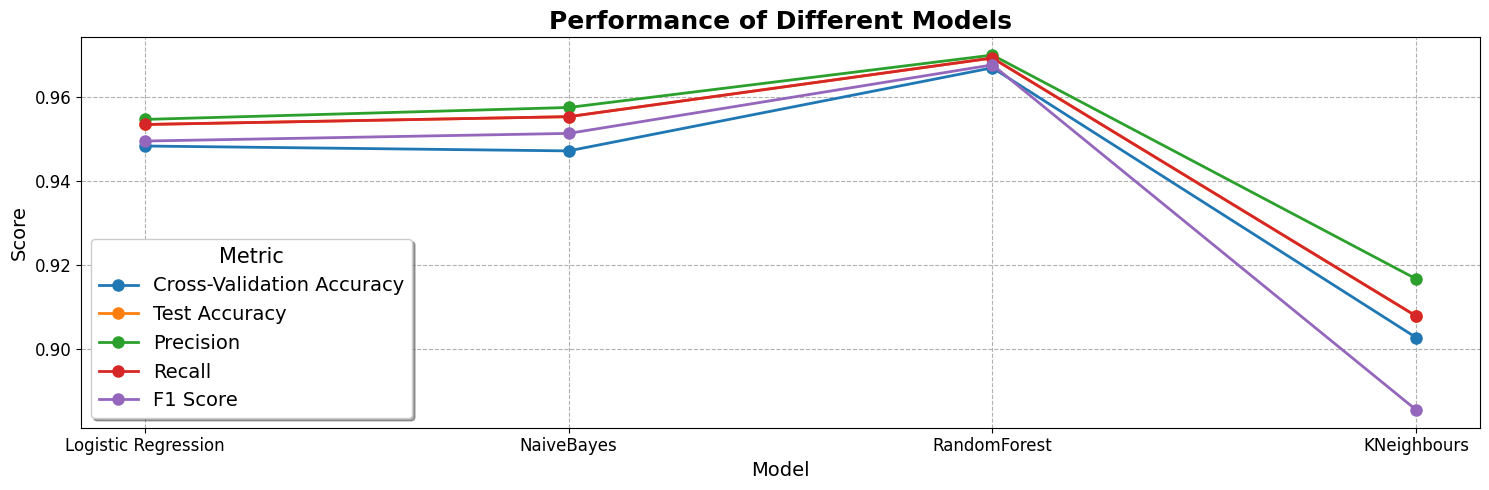

In [19]:
# Plotting Performance of Different Models
plt.figure(figsize=(15, 5))

for i, metric in enumerate(evaluation_df.columns[1:]):
    plt.plot(evaluation_df['Model'], evaluation_df[metric], marker='o', linestyle='-', linewidth=2, markersize=8, label=metric)

plt.title('Performance of Different Models', fontsize=18, fontweight='bold')
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=1)
plt.legend(title='Metric', title_fontsize='15', fontsize='14', loc='best', frameon=True, shadow=True)
plt.tight_layout()
plt.show()
